<a href="https://colab.research.google.com/github/soccer1356-2000/Ingong_MidtermExam/blob/main/%EC%A4%91%EA%B0%84%EA%B3%BC%EC%A0%9C_201920778_%EC%9D%B4%EC%8A%B9%EC%9C%A4_ResNet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
args={}
kwargs={}
args['batch_size']=32
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.9 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).
args['weight_decay']=1e-5

args['seed']=1 #random seed
args['log_interval']=5000 // args['batch_size']
args['cuda']=True


In [4]:
from torchvision import datasets, transforms # Fashion-MNIST dataset for PyTorch
# Download and load the FashionMNIST training data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True,
transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False,
transform = transform)

In [5]:
import torch
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args['batch_size'], shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=args['batch_size'], shuffle=True)

In [6]:
trainset # 28 * 28 * 1

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
def conv3x3(in_planes, out_planes, stride=1, groups=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, groups=groups, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [9]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64,  norm_layer=nn.BatchNorm2d):
      
        super().__init__()
            
        self.conv1 = conv3x3(inplanes, planes, stride)  
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out

In [10]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, norm_layer=nn.BatchNorm2d):
        super().__init__()

        # ResNext
        width = int(planes * (base_width / 64.)) * groups
        

        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups) # conv2에서 downsample
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        # 1x1 convolution layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # 3x3 convolution layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        # 1x1 convolution layer
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [11]:
class ResNet(nn.Module):
  def __init__(self, block, layers, zero_init_residual=False,
                 groups=1, width_per_group=64, norm_layer=nn.BatchNorm2d):
    super().__init__()
    self.norm_layer = norm_layer
    self.groups = groups
    self.base_width = width_per_group

    self.inplane = 64

    #stage 1
    self.conv1 = nn.Conv2d(1,self.inplane,kernel_size=7,stride = 2, padding = 3, bias = False)
    self.bn1 = norm_layer(self.inplane)
    self.relu = nn.ReLU(inplace = True)
    self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    #stage 2
    self.layer1 = self.make_layer(block,64,layers[0])
    #stage 3
    self.layer2 = self.make_layer(block,128,layers[1],stride=2)
    #stage 4
    self.layer3 = self.make_layer(block,256,layers[2],stride=2)
    #stage 5
    self.layer4 = self.make_layer(block,512,layers[3],stride=2)
    self.averpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512 * block.expansion,10)
  
  def make_layer(self,block,palnes,blocks,stride = 1):
    norm_layer = self.norm_layer

    down_channel = None
    
    if stride != 1 or self.inplane != block.expansion * palnes:
      down_channel = nn.Sequential(conv1x1(self.inplane, palnes * block.expansion,stride),norm_layer(palnes * block.expansion))

    layers = []

    layers.append(block(self.inplane, palnes, stride, down_channel, self.groups,self.base_width, norm_layer))
    self.inplane = palnes * block.expansion # inplanes 업데이트
    for _ in range(1, blocks):
        layers.append(block(self.inplane, palnes, groups=self.groups,base_width=self.base_width, norm_layer=norm_layer))
        self.inplane = palnes * block.expansion # inplanes 업데이트
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.averpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)

   # output = nn.log_softmax(x, dim=1)
    return F.log_softmax(x)

In [12]:
from torch.autograd import Variable
import torch.optim as optim

In [13]:
def train(epoch):
    model.train()
    train_correct = 0
    for batch_idx, (data, target) in enumerate(trainloader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data)
        train_pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += train_pred.eq(target.data.view_as(train_pred)).long().cpu().sum()
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            train_correct = 0
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data))
    train_acc.insert(len(train_acc),(100. * train_correct / len(trainloader.dataset)))
def test():
    model.eval()
    test_loss = 0
    correct = 0
    correct_top5 = 0
    total = 0
    total_r=0
    correct_top1=0
    for data, target in testloader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

        _, predicted = torch.topk(output, k=5, dim=1)
        total += target.size(0)
        correct_top5 += sum([1 if label in predicted[i] else 0  for i,label in enumerate(target)])

        __, predicted_r = torch.max(output, 1)
        total_r += target.size(0)
        correct_top1 += (predicted_r == target).sum().item()

    test_loss /= len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    test_acc.insert(len(test_acc),(100. * correct / len(testloader.dataset)))
    top5_accuracy = correct_top5 / total
    print(f"Top-5 Accuracy: {top5_accuracy}")
    top1_accuracy = correct_top1 / total_r
    print(f"Top-1 Accuracy: {top1_accuracy}\n")
  

In [14]:
pip install ptflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.7-py3-none-any.whl size=11076 sha256=43dcceae34cadf637834026e2180774584edde3d5ac0db3b8bc46d261870cde2
  Stored in directory: /root/.cache/pip/wheels/b9/54/3b/f84523431ce82e08462644d279c0e13a51a00236e237e6bc7e
Successfully built ptflops


In [15]:
import matplotlib.pyplot as plt
from ptflops import get_model_complexity_info
import math
import time

In [ ]:
start = time.time()
model = ResNet(Bottleneck,[3,4,6,3])
train_acc = []
test_acc = []

if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'],weight_decay=args['weight_decay'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

end = time.time()

print(f"{end - start:.5f} sec")

with torch.cuda.device(0):

  input_tensor = torch.randn(1, 1, 224, 224).cuda()

  flops, params = get_model_complexity_info(model, (1, 224, 224), as_strings=True, print_per_layer_stat=True)

  print('FLOPs:', flops)

  print('Parameters:', params)


print(test_acc)
print(train_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot([i for i in range(1,len(test_acc)+1)], test_acc, color ="blue")
a = plt.twinx()
a.plot([i for i in range(1,len(train_acc)+1)], train_acc, color = "red")
plt.show()


<ipython-input-43-36c03540b093>:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.571348
Train Epoch: 1 [4992/60000 (8%)]	Loss: 2.400527
Train Epoch: 1 [9984/60000 (17%)]	Loss: 1.483584
Train Epoch: 1 [14976/60000 (25%)]	Loss: 1.572399
Train Epoch: 1 [19968/60000 (33%)]	Loss: 2.191091
Train Epoch: 1 [24960/60000 (42%)]	Loss: 0.942178
Train Epoch: 1 [29952/60000 (50%)]	Loss: 3.502592
Train Epoch: 1 [34944/60000 (58%)]	Loss: 2.538315
Train Epoch: 1 [39936/60000 (67%)]	Loss: 5.870281
Train Epoch: 1 [44928/60000 (75%)]	Loss: 1.016972
Train Epoch: 1 [49920/60000 (83%)]	Loss: 1.162630
Train Epoch: 1 [54912/60000 (92%)]	Loss: 0.580461
Train Epoch: 1 [59904/60000 (100%)]	Loss: 1.195467


<ipython-input-46-d3b87ec97dcd>:38: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test set: Average loss: 1.0329, Accuracy: 6250/10000 (62%)
Top-5 Accuracy: 0.9835
Top-1 Accuracy: 0.625

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.775056
Train Epoch: 2 [4992/60000 (8%)]	Loss: 1.807752
Train Epoch: 2 [9984/60000 (17%)]	Loss: 0.905820
Train Epoch: 2 [14976/60000 (25%)]	Loss: 2.804996
Train Epoch: 2 [19968/60000 (33%)]	Loss: 0.983391
Train Epoch: 2 [24960/60000 (42%)]	Loss: 4.796560
Train Epoch: 2 [29952/60000 (50%)]	Loss: 0.923590
Train Epoch: 2 [34944/60000 (58%)]	Loss: 4.763465
Train Epoch: 2 [39936/60000 (67%)]	Loss: 0.700604
Train Epoch: 2 [44928/60000 (75%)]	Loss: 0.634912
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.648374
Train Epoch: 2 [54912/60000 (92%)]	Loss: 0.420335
Train Epoch: 2 [59904/60000 (100%)]	Loss: 0.286328

Test set: Average loss: 0.6659, Accuracy: 7757/10000 (78%)
Top-5 Accuracy: 0.9956
Top-1 Accuracy: 0.7757

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.597273
Train Epoch: 3 [4992/60000 (8%)]	Loss: 0.757632
Train Epoch: 3 [9984/60000 (17%)]	Loss: 0.641658
Tr

KeyboardInterrupt: ignored

<ipython-input-11-36c03540b093>:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.707015
Train Epoch: 1 [4992/60000 (8%)]	Loss: 1.704679
Train Epoch: 1 [9984/60000 (17%)]	Loss: 0.821777
Train Epoch: 1 [14976/60000 (25%)]	Loss: 1.378377
Train Epoch: 1 [19968/60000 (33%)]	Loss: 4.143837
Train Epoch: 1 [24960/60000 (42%)]	Loss: 0.519479
Train Epoch: 1 [29952/60000 (50%)]	Loss: 0.704641
Train Epoch: 1 [34944/60000 (58%)]	Loss: 0.607279
Train Epoch: 1 [39936/60000 (67%)]	Loss: 1.296994
Train Epoch: 1 [44928/60000 (75%)]	Loss: 0.625946
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.548169
Train Epoch: 1 [54912/60000 (92%)]	Loss: 1.012455
Train Epoch: 1 [59904/60000 (100%)]	Loss: 0.309120


<ipython-input-13-d3b87ec97dcd>:38: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.6072, Accuracy: 7902/10000 (79%)
Top-5 Accuracy: 0.9944
Top-1 Accuracy: 0.7902

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.552678
Train Epoch: 2 [4992/60000 (8%)]	Loss: 0.390429
Train Epoch: 2 [9984/60000 (17%)]	Loss: 0.648274
Train Epoch: 2 [14976/60000 (25%)]	Loss: 0.308045
Train Epoch: 2 [19968/60000 (33%)]	Loss: 0.379134
Train Epoch: 2 [24960/60000 (42%)]	Loss: 0.964928
Train Epoch: 2 [29952/60000 (50%)]	Loss: 0.438013
Train Epoch: 2 [34944/60000 (58%)]	Loss: 0.522075
Train Epoch: 2 [39936/60000 (67%)]	Loss: 0.523011
Train Epoch: 2 [44928/60000 (75%)]	Loss: 0.469957
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.499711
Train Epoch: 2 [54912/60000 (92%)]	Loss: 0.369099
Train Epoch: 2 [59904/60000 (100%)]	Loss: 0.381003

Test set: Average loss: 0.8420, Accuracy: 8268/10000 (83%)
Top-5 Accuracy: 0.9951
Top-1 Accuracy: 0.8268

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.331210
Train Epoch: 3 [4992/60000 (8%)]	Loss: 0.419902
Train Epoch: 3 [9984/60000 (17%)]	Loss: 0.570699
T

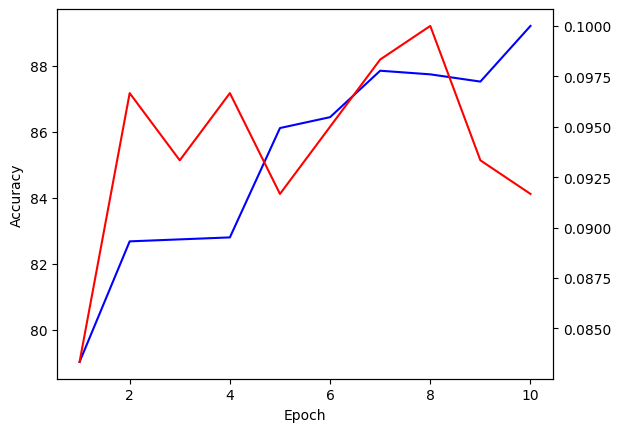

In [16]:
#ResNeXt
torch.cuda.empty_cache()
start = time.time()
model = ResNet(Bottleneck,[3,4,6,3],groups=32)
train_acc = []
test_acc = []

if args['cuda']:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'],weight_decay=args['weight_decay'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

end = time.time()
print(f"{end - start:.5f} sec")

with torch.cuda.device(0):

  input_tensor = torch.randn(1, 1, 224, 224).cuda()

  flops, params = get_model_complexity_info(model, (1, 224, 224), as_strings=True, print_per_layer_stat=True)

  print('FLOPs:', flops)

  print('Parameters:', params)


print(test_acc)
print(train_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot([i for i in range(1,len(test_acc)+1)], test_acc, color ="blue")
a = plt.twinx()
a.plot([i for i in range(1,len(train_acc)+1)], train_acc, color = "red")
plt.show()
